# GMM Model Optimization - December 30 Data (2-Cluster Classification)

This notebook implements:
- Data loading from COLD, HOT, NORMAL folders
- Merging COLD and NORMAL into one class (COLD_OR_NORMAL vs HOT)
- Statistical feature engineering only
- GMM model training with 2 clusters
- Model evaluation and selection
- Best model saving


In [11]:
import pickle
import numpy as np
import pandas as pd
import warnings
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# Set style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")


## 1. Data Loading Functions


In [12]:
def load_sensor_data_from_csv(csv_path):
    """Load sensor readings from raw sensor log CSV file."""
    try:
        df = pd.read_csv(csv_path)
        columns = df.columns.str.lower()
        
        sensor_cols = []
        for i in range(1, 5):
            for pattern in [f'sensor_{i}', f'sensor-{i}', f'sensor {i}']:
                if pattern in columns:
                    sensor_cols.append(df.columns[columns == pattern][0])
                    break
        
        if len(sensor_cols) != 4:
            sensor_cols = [col for col in df.columns if 'sensor' in col.lower() and any(str(i) in col for i in [1,2,3,4])]
            sensor_cols = sorted(sensor_cols)[:4]
        
        if len(sensor_cols) != 4:
            return None
        
        status_col = None
        for col in df.columns:
            if 'status' in col.lower():
                status_col = col
                break
        
        if status_col:
            valid_mask = df[status_col].str.upper() == 'VALID'
            df_valid = df[valid_mask].copy()
        else:
            df_valid = df.copy()
            if len(df_valid) > 0:
                first_val = df_valid[sensor_cols[0]].iloc[0]
                if isinstance(first_val, str) and 'sensor' in str(first_val).lower():
                    df_valid = df_valid.iloc[1:]
        
        if len(df_valid) == 0:
            return None
        
        sensor_data = df_valid[sensor_cols].values.astype(float)
        return sensor_data
        
    except Exception as e:
        return None


def load_all_data():
    """Load all sensor data from COLD, HOT, NORMAL folders."""
    data_path = Path('.')
    
    X_all = []
    y_all = []
    
    ground_truth_map = {'COLD': 'COLD', 'HOT': 'HOT', 'NORMAL': 'NORMAL'}
    
    for folder_name in ['COLD', 'HOT', 'NORMAL']:
        folder_path = data_path / folder_name
        if not folder_path.exists():
            continue
        
        ground_truth_class = ground_truth_map.get(folder_name, folder_name.upper())
        csv_files = sorted(folder_path.glob('raw_sensor_log*.csv'))
        
        for csv_file in csv_files:
            sensor_data = load_sensor_data_from_csv(csv_file)
            if sensor_data is not None and len(sensor_data) > 0:
                X_all.append(sensor_data)
                y_all.extend([ground_truth_class] * len(sensor_data))
    
    if not X_all:
        return None, None
    
    X = np.vstack(X_all)
    y = np.array(y_all)
    return X, y


## 2. Load Data and Split


In [13]:
# Load data
print("=" * 80)
print("LOADING DATA")
print("=" * 80)

X, y = load_all_data()

if X is None:
    print("Failed to load data!")
else:
    print(f"\nTotal samples: {len(X):,}")
    print(f"Features per sample: {X.shape[1]} (raw sensors)")
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution:")
    for cls, cnt in zip(unique, counts):
        print(f"  {cls}: {cnt:,} samples ({cnt/len(y)*100:.1f}%)")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nTrain set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Test set:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")


LOADING DATA

Total samples: 4,401
Features per sample: 4 (raw sensors)

Class distribution:
  COLD: 1,406 samples (31.9%)
  HOT: 1,367 samples (31.1%)
  NORMAL: 1,628 samples (37.0%)

Train set: 3,520 samples (80.0%)
Test set:  881 samples (20.0%)


## 3. Statistical Feature Engineering


In [14]:
def feature_engineering_v1(X):
    """Basic statistical features: 12 features"""
    X = np.array(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    # Statistical features only
    sensor_mean = X.mean(axis=1)
    sensor_std = X.std(axis=1)
    sensor_var = X.var(axis=1)
    sensor_sum = X.sum(axis=1)
    sensor_max = X.max(axis=1)
    sensor_min = X.min(axis=1)
    sensor_range = sensor_max - sensor_min
    sensor_median = np.median(X, axis=1)
    
    return np.column_stack([X, sensor_mean, sensor_std, sensor_var, sensor_sum, 
                           sensor_max, sensor_min, sensor_range, sensor_median])


def feature_engineering_v2(X):
    """Enhanced statistical features: 15 features"""
    X = np.array(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    # Statistical features
    sensor_sum = X.sum(axis=1)
    sensor_mean = X.mean(axis=1)
    sensor_std = X.std(axis=1)
    sensor_var = X.var(axis=1)
    sensor_median = np.median(X, axis=1)
    
    # Range features
    sensor_max = X.max(axis=1)
    sensor_min = X.min(axis=1)
    sensor_range = sensor_max - sensor_min
    
    # Percentiles
    sensor_q25 = np.percentile(X, 25, axis=1)
    sensor_q75 = np.percentile(X, 75, axis=1)
    sensor_iqr = sensor_q75 - sensor_q25
    
    return np.column_stack([X, sensor_sum, sensor_mean, sensor_std, sensor_var, sensor_median,
                           sensor_max, sensor_min, sensor_range, sensor_q25, sensor_q75, sensor_iqr])


def feature_engineering_v3(X):
    """Comprehensive statistical features: 14 features"""
    X = np.array(X)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    # Comprehensive statistical features
    sensor_sum = X.sum(axis=1)
    sensor_mean = X.mean(axis=1)
    sensor_std = X.std(axis=1)
    sensor_var = X.var(axis=1)
    sensor_median = np.median(X, axis=1)
    
    # Range features
    sensor_max = X.max(axis=1)
    sensor_min = X.min(axis=1)
    sensor_range = sensor_max - sensor_min
    
    # Additional moments
    mean_centered = X - sensor_mean[:, np.newaxis]
    sensor_skew = (mean_centered ** 3).mean(axis=1) / (sensor_std ** 3 + 1e-8)
    
    # Percentiles
    sensor_q25 = np.percentile(X, 25, axis=1)
    sensor_q75 = np.percentile(X, 75, axis=1)
    sensor_iqr = sensor_q75 - sensor_q25
    
    return np.column_stack([
        X,  # 4 raw
        sensor_sum, sensor_mean, sensor_std, sensor_var, sensor_median,  # 5 basic stats
        sensor_max, sensor_min, sensor_range,  # 3 range
        sensor_skew,  # 1 moment
        sensor_q25, sensor_q75, sensor_iqr  # 3 percentiles
    ])


print("Feature Engineering Functions Defined:")
print(f"  v1: {feature_engineering_v1(np.array([[100, 200, 300, 400]])).shape[1]} features")
print(f"  v2: {feature_engineering_v2(np.array([[100, 200, 300, 400]])).shape[1]} features")
print(f"  v3: {feature_engineering_v3(np.array([[100, 200, 300, 400]])).shape[1]} features")


Feature Engineering Functions Defined:
  v1: 12 features
  v2: 15 features
  v3: 16 features


## 4. Cluster-to-Temperature Mapping


In [15]:
def map_clusters_to_temperature(clusters, ground_truth):
    """Map cluster IDs to temperature classes using majority voting."""
    cluster_to_temp = {}
    unique_clusters = np.unique(clusters)
    
    for cluster_id in unique_clusters:
        cluster_mask = clusters == cluster_id
        temps_in_cluster = pd.Series(ground_truth[cluster_mask]).value_counts()
        
        if len(temps_in_cluster) > 0:
            dominant_temp = temps_in_cluster.idxmax()
            cluster_to_temp[int(cluster_id)] = dominant_temp
        else:
            cluster_to_temp[int(cluster_id)] = 'NORMAL'
    
    return cluster_to_temp


## 5. Model Evaluation Function


In [16]:
def evaluate_configuration(X_train, y_train, X_test, y_test, feature_func, feat_name, 
                          cov_type='tied', n_init=30, random_state=42):
    """Evaluate a specific model configuration."""
    
    # Feature engineering
    X_train_feat = feature_func(X_train)
    X_test_feat = feature_func(X_test)
    
    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_feat)
    X_test_scaled = scaler.transform(X_test_feat)
    
    # Train GMM with 2 clusters
    gmm = GaussianMixture(
        n_components=2,
        covariance_type=cov_type,
        random_state=random_state,
        max_iter=300,
        n_init=n_init,
        init_params='kmeans'
    )
    gmm.fit(X_train_scaled)
    
    if not gmm.converged_:
        return None
    
    # Predict
    clusters_train = gmm.predict(X_train_scaled)
    clusters_test = gmm.predict(X_test_scaled)
    
    # Map clusters
    cluster_to_temp = map_clusters_to_temperature(clusters_train, y_train)
    
    # Evaluate
    pred_train = np.array([cluster_to_temp.get(c, 'COLD_OR_NORMAL') for c in clusters_train])
    pred_test = np.array([cluster_to_temp.get(c, 'COLD_OR_NORMAL') for c in clusters_test])
    
    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)
    test_f1 = f1_score(y_test, pred_test, average='weighted', zero_division=0, labels=['COLD_OR_NORMAL', 'HOT'])
    test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=0, labels=['COLD_OR_NORMAL', 'HOT'])
    test_recall = recall_score(y_test, pred_test, average='weighted', zero_division=0, labels=['COLD_OR_NORMAL', 'HOT'])
    
    # Per-class accuracy
    conf_matrix = confusion_matrix(y_test, pred_test, labels=['COLD_OR_NORMAL', 'HOT'])
    per_class_acc = {}
    for i, label in enumerate(['COLD_OR_NORMAL', 'HOT']):
        if conf_matrix[i].sum() > 0:
            per_class_acc[label] = conf_matrix[i, i] / conf_matrix[i].sum()
        else:
            per_class_acc[label] = 0.0
    
    # Calculate balanced score (for 2 classes)
    n_classes_predicted = len(set([cluster_to_temp.get(c, 'COLD_OR_NORMAL') for c in range(2)]))
    balanced_score = test_acc * (0.7 + 0.3 * (n_classes_predicted / 2))
    
    return {
        'feature_name': feat_name,
        'n_features': X_train_feat.shape[1],
        'covariance_type': cov_type,
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc),
        'test_f1': float(test_f1),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'per_class_accuracy': per_class_acc,
        'n_classes_predicted': n_classes_predicted,
        'balanced_score': float(balanced_score),
        'gmm': gmm,
        'scaler': scaler,
        'cluster_mapping': cluster_to_temp,
        'confusion_matrix': conf_matrix.tolist(),
        'converged': gmm.converged_,
        'n_iter': int(gmm.n_iter_)
    }


## 6. Model Optimization


In [17]:
print("=" * 80)
print("MODEL OPTIMIZATION")
print("=" * 80)

# Test all configurations
configurations = [
    (feature_engineering_v1, 'v1_basic', 'tied'),
    (feature_engineering_v1, 'v1_basic', 'full'),
    (feature_engineering_v1, 'v1_basic', 'diag'),
    (feature_engineering_v2, 'v2_enhanced', 'tied'),
    (feature_engineering_v2, 'v2_enhanced', 'full'),
    (feature_engineering_v2, 'v2_enhanced', 'diag'),
    (feature_engineering_v3, 'v3_comprehensive', 'tied'),
    (feature_engineering_v3, 'v3_comprehensive', 'full'),
    (feature_engineering_v3, 'v3_comprehensive', 'diag'),
]

all_results = []

for i, (feat_func, feat_name, cov_type) in enumerate(configurations, 1):
    print(f"\n[{i}/{len(configurations)}] Testing: {feat_name} features, {cov_type} covariance...", end=' ')
    try:
        result = evaluate_configuration(X_train, y_train, X_test, y_test, feat_func, feat_name, cov_type)
        if result:
            all_results.append(result)
            print(f"Acc: {result['test_accuracy']:.4f}, Classes: {result['n_classes_predicted']}/2")
        else:
            print("Failed (no convergence)")
    except Exception as e:
        print(f"Error: {e}")
        continue

print(f"\n\nTotal successful configurations: {len(all_results)}")


MODEL OPTIMIZATION

[1/9] Testing: v1_basic features, tied covariance... 

Acc: 0.3961, Classes: 2/2

[2/9] Testing: v1_basic features, full covariance... Acc: 0.3791, Classes: 2/2

[3/9] Testing: v1_basic features, diag covariance... Acc: 0.4132, Classes: 2/2

[4/9] Testing: v2_enhanced features, tied covariance... Acc: 0.4007, Classes: 2/2

[5/9] Testing: v2_enhanced features, full covariance... Acc: 0.3700, Classes: 1/2

[6/9] Testing: v2_enhanced features, diag covariance... Acc: 0.4166, Classes: 2/2

[7/9] Testing: v3_comprehensive features, tied covariance... Acc: 0.4007, Classes: 2/2

[8/9] Testing: v3_comprehensive features, full covariance... Acc: 0.3700, Classes: 1/2

[9/9] Testing: v3_comprehensive features, diag covariance... Acc: 0.4188, Classes: 2/2


Total successful configurations: 9


## 7. Results Analysis


In [18]:
if len(all_results) > 0:
    # Sort by balanced score
    all_results.sort(key=lambda x: x['balanced_score'], reverse=True)
    
    print("=" * 80)
    print("RESULTS SUMMARY")
    print("=" * 80)
    print(f"\n{'Rank':<6} {'Features':<25} {'Cov':<8} {'Test Acc':<12} {'Test F1':<12} {'Classes':<8}")
    print("-" * 80)
    for i, r in enumerate(all_results[:10], 1):
        print(f"{i:<6} {r['feature_name']:<25} {r['covariance_type']:<8} "
              f"{r['test_accuracy']:<12.4f} {r['test_f1']:<12.4f} {r['n_classes_predicted']:<8}")
    
    # Best model
    best_result = all_results[0]
    
    print("\n" + "=" * 80)
    print("BEST MODEL")
    print("=" * 80)
    print(f"Features: {best_result['feature_name']} ({best_result['n_features']} features)")
    print(f"Covariance Type: {best_result['covariance_type']}")
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {best_result['test_accuracy']:.4f} ({best_result['test_accuracy']*100:.2f}%)")
    print(f"  Precision: {best_result['test_precision']:.4f}")
    print(f"  Recall:    {best_result['test_recall']:.4f}")
    print(f"  F1-Score:  {best_result['test_f1']:.4f}")
    
    print(f"\nPer-Class Accuracy:")
    for cls, acc in best_result['per_class_accuracy'].items():
        print(f"  {cls}: {acc:.4f} ({acc*100:.2f}%)")
    
    print(f"\nCluster Mapping:")
    for cluster_id, temp_class in sorted(best_result['cluster_mapping'].items()):
        print(f"  Cluster {cluster_id} -> {temp_class}")
    
    # Confusion matrix
    conf_matrix = np.array(best_result['confusion_matrix'])
    print(f"\nConfusion Matrix:")
    print(f"                    Pred COLD_OR_NORMAL  Pred HOT")
    for i, label in enumerate(['COLD_OR_NORMAL', 'HOT']):
        print(f"True {label:18}: {conf_matrix[i, 0]:18}  {conf_matrix[i, 1]:8}")


RESULTS SUMMARY

Rank   Features                  Cov      Test Acc     Test F1      Classes 
--------------------------------------------------------------------------------
1      v3_comprehensive          diag     0.4188       0.0000       2       
2      v2_enhanced               diag     0.4166       0.0000       2       
3      v1_basic                  diag     0.4132       0.0000       2       
4      v2_enhanced               tied     0.4007       0.0000       2       
5      v3_comprehensive          tied     0.4007       0.0000       2       
6      v1_basic                  tied     0.3961       0.0000       2       
7      v1_basic                  full     0.3791       0.0000       2       
8      v2_enhanced               full     0.3700       0.0000       1       
9      v3_comprehensive          full     0.3700       0.0000       1       

BEST MODEL
Features: v3_comprehensive (16 features)
Covariance Type: diag

Test Set Performance:
  Accuracy:  0.4188 (41.88%)
  Pre

## 8. Visualization


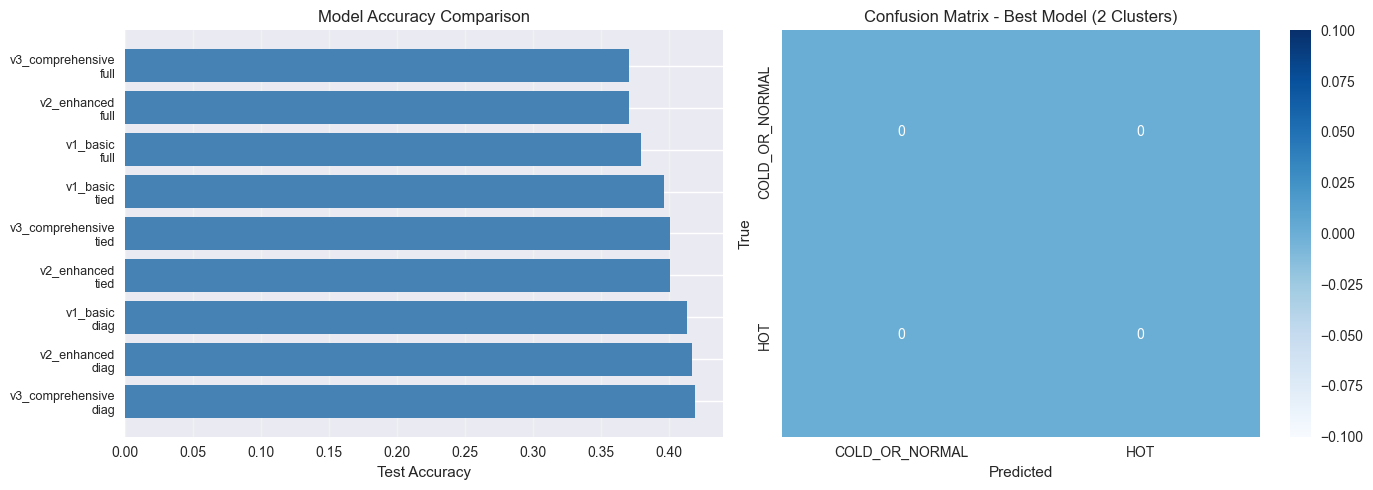


Visualization saved as 'model_comparison.png'


In [19]:
if len(all_results) > 0:
    # Create comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy comparison
    results_df = pd.DataFrame([
        {
            'Config': f"{r['feature_name']}\n{r['covariance_type']}",
            'Accuracy': r['test_accuracy'],
            'F1': r['test_f1']
        }
        for r in all_results
    ])
    
    axes[0].barh(range(len(results_df)), results_df['Accuracy'], color='steelblue')
    axes[0].set_yticks(range(len(results_df)))
    axes[0].set_yticklabels(results_df['Config'], fontsize=9)
    axes[0].set_xlabel('Test Accuracy')
    axes[0].set_title('Model Accuracy Comparison')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Confusion matrix heatmap
    conf_matrix = np.array(best_result['confusion_matrix'])
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=['COLD_OR_NORMAL', 'HOT'],
                yticklabels=['COLD_OR_NORMAL', 'HOT'])
    axes[1].set_title('Confusion Matrix - Best Model (2 Clusters)')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved as 'model_comparison.png'")


## 9. Save Best Model


In [20]:
if len(all_results) > 0:
    best_result = all_results[0]
    
    print("=" * 80)
    print("SAVING BEST MODEL")
    print("=" * 80)
    
    model_package = {
        'gmm_model': best_result['gmm'],
        'scaler': best_result['scaler'],
        'cluster_to_temp_mapping': best_result['cluster_mapping'],
        'n_clusters': 2,
        'n_features': best_result['n_features'],
        'feature_engineering': best_result['feature_name'],
        'covariance_type': best_result['covariance_type'],
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'test_accuracy': best_result['test_accuracy'],
        'test_precision': best_result['test_precision'],
        'test_recall': best_result['test_recall'],
        'test_f1': best_result['test_f1'],
        'per_class_accuracy': best_result['per_class_accuracy'],
        'note': 'COLD and NORMAL classes merged into COLD_OR_NORMAL'
    }
    
    model_file = 'gmm_model_best.pkl'
    with open(model_file, 'wb') as f:
        pickle.dump(model_package, f)
    print(f"\nModel saved: {model_file}")
    
    # Save metadata
    metadata = {
        'timestamp': datetime.now().isoformat(),
        'best_model': {
            'feature_name': best_result['feature_name'],
            'n_features': best_result['n_features'],
            'covariance_type': best_result['covariance_type'],
            'test_accuracy': best_result['test_accuracy'],
            'test_f1': best_result['test_f1'],
            'n_classes_predicted': best_result['n_classes_predicted'],
            'per_class_accuracy': best_result['per_class_accuracy']
        },
        'all_configurations': [
            {
                'feature_name': r['feature_name'],
                'n_features': r['n_features'],
                'covariance_type': r['covariance_type'],
                'test_accuracy': r['test_accuracy'],
                'test_f1': r['test_f1'],
                'n_classes_predicted': r['n_classes_predicted']
            }
            for r in all_results
        ]
    }
    
    metadata_file = 'model_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Metadata saved: {metadata_file}")
    
    print("\n" + "=" * 80)
    print("OPTIMIZATION COMPLETE!")
    print("=" * 80)


SAVING BEST MODEL

Model saved: gmm_model_best.pkl
Metadata saved: model_metadata.json

OPTIMIZATION COMPLETE!
